In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline

### Loading Data

In [2]:
TRAIN_DIR = '../Data/Kaggle/DogsVsCats/train/'
TEST_DIR  = '../Data/Kaggle/DogsVsCats/test/'

train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

valid_images = [TEST_DIR+i for i in os.listdir(TEST_DIR)]

In [3]:
import cv2

labels = []
images = []
size = 64

for p in train_dogs:
    images.append(cv2.resize(cv2.imread(p, cv2.IMREAD_COLOR), (size, size), interpolation=cv2.INTER_CUBIC))
    labels.append('dog')
    
for p in train_cats:
    images.append(cv2.resize(cv2.imread(p, cv2.IMREAD_COLOR), (size, size), interpolation=cv2.INTER_CUBIC))
    labels.append('cat')

In [4]:
X = np.array(images)[:2000]
y = np.array(labels)[:2000]

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
print(X_train.shape)
print(y_train.shape)

(20000, 64, 64, 3)
(20000,)


In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train, random_state=0)

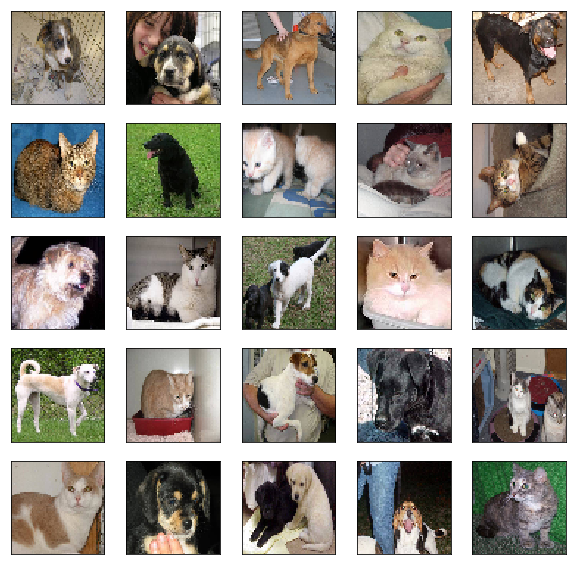

In [8]:
f, axes = plt.subplots(5, 5, figsize=(10, 10))
for index, image in enumerate(X_train[:25]):
    axes[int(index/5)][int(index%5)].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), interpolation='nearest')
    axes[int(index/5)][int(index%5)].set_xticks(np.array([]))
    axes[int(index/5)][int(index%5)].set_yticks(np.array([]))

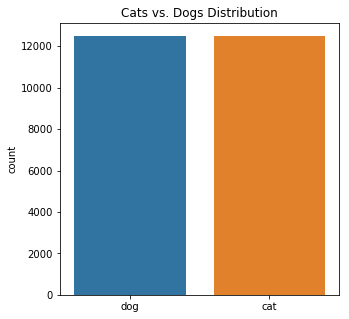

In [9]:
plt.figure(figsize=(5,5))
sns.countplot(labels)
plt.title('Cats vs. Dogs Distribution')

### Pre-Processing

In [10]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype('float32').reshape(X_train.shape[0], -1))
X_valid = scaler.transform(X_valid.astype('float32').reshape(X_valid.shape[0], -1))

In [11]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y_train)
y_train = le.transform(y_train) 
y_valid = le.transform(y_valid) 

In [12]:
X_train = X_train.astype('float32').reshape(X_train.shape[0], size, size, 3)
X_valid = X_valid.astype('float32').reshape(X_valid.shape[0], size, size, 3)

In [13]:
print(X_train.shape)
print(y_train.shape)

(20000, 64, 64, 3)
(20000,)


### Modeling

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
from keras import optimizers

Using TensorFlow backend.


In [15]:
def plot_history(history, x, y):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.figure(figsize=(x, y))
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.figure(figsize=(x, y))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='best')

In [16]:
input_shape = (size, size, 3)

def create_model(init='he_normal', optim='adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(6, 6), activation='relu', input_shape=input_shape, padding='same', name='b1_conv'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='b1_poll'))
    
    model.add(Conv2D(128, kernel_size=(6, 6), activation='relu', padding='same', name='b2_conv'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='b2_pool'))
    
    model.add(Conv2D(256, kernel_size=(6, 6), activation='relu', padding='same', name='b3_conv'))
    model.add(MaxPooling2D(pool_size=(2, 2), name='b3_pool'))
    
    model.add(Flatten())
    model.add(Dense(500, activation='relu', name='fc1'))
    model.add(Dropout(0.5))
    
    model.add(Dense(500, activation='relu', name='fc2'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid', name='prediction'))
    model.compile(optimizer=optim, loss='binary_crossentropy',  metrics=['accuracy'])
    
    return model

In [17]:
def generator(features, labels, batch_size):
    # Create empty arrays to contain batch of features and labels
    batch_features = np.zeros((batch_size, size, size, 3))
    batch_labels = np.zeros((batch_size, 1))
    while True:
        for i in range(batch_size):
            # choose random index in features
            index = np.random.choice(len(features),1)
            batch_features[i] = features[index]
            batch_labels[i] = labels[index]
        yield batch_features, batch_labels

Let's use early stop to break the fitting when no improvement is achieved.

In [19]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')   

In [ ]:
import time

batch_size = 16

start_time = time.time()

clf = create_model(optim='adam')
hist = clf.fit_generator(generator(X_train, y_train, batch_size=batch_size),
                         steps_per_epoch=X_train.shape[0] // batch_size,
                         epochs=100, verbose=0, validation_data=(X_valid, y_valid))


print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
plot_history(hist, 10, 5)

In [ ]:
scores = clf.model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.model.metrics_names[1], scores[1]*100))

### Testing

In [ ]:
images = []

for p in train_cats:
    images.append(cv2.resize(cv2.imread(p, cv2.IMREAD_COLOR), (size, size), interpolation=cv2.INTER_CUBIC))

In [ ]:
X_train = np.array(images)

In [ ]:
X_test  = scaler.transform(X_test.astype('float32').reshape(X_test.shape[0], -1))
X_test  = X_test.astype('float32').reshape(X_test.shape[0], size, size, 3)

y_test = le.transform(y_test) 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

y_pred = clf.model.predict(X_test)
cf = confusion_matrix(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))

df_cm = pd.DataFrame(cf, index=set(labels), columns=set(labels))

plt.figure(figsize = (8, 8))
sns.heatmap(df_cm, annot=True, cmap=plt.cm.Blues)
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(np.argmax(y_pred, axis=1), np.argmax(y_test, axis=1))))
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Layers Visualization

In [ ]:
from vis.visualization import visualize_activation
from vis.utils import utils
from vis.input_modifiers import Jitter

from keras import activations

#### Dense layer Activation

In [ ]:
layer_idx = utils.find_layer_idx(model, 'preds')

model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

filter_idx = 0

In [ ]:
f, axes = plt.subplots(1, n_target, figsize=(20, 5))

vis_images = []
for output_idx in np.arange(n_target):
    # We will seed with optimized image this time.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.), input_modifiers=[Jitter(16)])
    axes[output_idx].imshow(img[..., 0], cmap='viridis')
    axes[output_idx].set_xticks(np.array([]))
    axes[output_idx].set_yticks(np.array([]))
    axes[output_idx].set_title(str(unique[output_idx]))